In [1]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #
!pip install ipython-autotime
%load_ext autotime
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=e38bb476d6b03c8f45b949b484d8b243950fcdccc082a185e7ca8d2041cb15df
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
# Hyper-parameters
num_epochs = 80
learning_rate = 0.01
batch_size=512

time: 1.39 ms


In [3]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    #transforms.RandomRotation(degrees=[-10,10], resample=False, expand=False, center=None, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

time: 4.58 ms


In [0]:
#transform_train = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor(),
#    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [4]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transform_test)

Extracting ../../data/cifar-10-python.tar.gz to ../../data/
time: 9.87 s


In [5]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



time: 5.18 ms


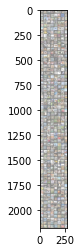

 ship horse   car truck
time: 656 ms


In [6]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

time: 1.6 ms


In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        #dropout=0.4
        #dropout = 0 if dropout is None else dropout
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        #self.dropout = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        #out = self.dropout(out)
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

time: 20.2 ms


In [9]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        dropout=0.30
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.dropout = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.dropout(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

time: 19.4 ms


In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

time: 22.4 ms


In [11]:
#RESNET-18
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
#RESNET-34
#model = ResNet(BasicBlock, [3,4,6,3]).to(device)
#RESNET-50
#model = ResNet(Bottleneck, [3,4,6,3]).to(device)
#RESNET-101
#model = ResNet(Bottleneck, [3,4,23,3]).to(device)
#RESNET-152
#model = ResNet(Bottleneck, [3,8,36,3]).to(device)


time: 8.91 s


In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

time: 5.6 ms


In [13]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):

    if (epoch+1) % 10 == 0:
      if batch_size>2:
        batch_size /= 2
      else:
        batch_size=2
    else:
      batch_size
    
    correct = 0
    total = 0
    for i,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #if (i+1) % 100 == 0:
          
    print ("Epoch [{}/{}], Batch_size: {}  Train Loss: {:.4f} Train Accuracy: {} %"
                   .format(epoch+1, num_epochs, batch_size,  loss.item(),round((100 * correct / total),2)))
    #print(batch_size)
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/80], Batch_size: 512  Train Loss: 1.7540 Train Accuracy: 33.13 %
Epoch [2/80], Batch_size: 512  Train Loss: 1.3253 Train Accuracy: 48.36 %
Epoch [3/80], Batch_size: 512  Train Loss: 1.1602 Train Accuracy: 56.14 %
Epoch [4/80], Batch_size: 512  Train Loss: 1.0393 Train Accuracy: 62.26 %
Epoch [5/80], Batch_size: 512  Train Loss: 0.9431 Train Accuracy: 67.65 %
Epoch [6/80], Batch_size: 512  Train Loss: 0.6686 Train Accuracy: 71.13 %
Epoch [7/80], Batch_size: 512  Train Loss: 0.6532 Train Accuracy: 74.23 %
Epoch [8/80], Batch_size: 512  Train Loss: 0.6639 Train Accuracy: 76.1 %
Epoch [9/80], Batch_size: 512  Train Loss: 0.7294 Train Accuracy: 78.85 %
Epoch [10/80], Batch_size: 256.0  Train Loss: 0.6306 Train Accuracy: 80.1 %
Epoch [11/80], Batch_size: 256.0  Train Loss: 0.5084 Train Accuracy: 81.32 %
Epoch [12/80], Batch_size: 256.0  Train Loss: 0.5815 Train Accuracy: 82.31 %
Epoch [13/80], Batch_size: 256.0  Train Loss: 0.4834 Train Accuracy: 83.26 %
Epoch [14/80], Batch_size: 2

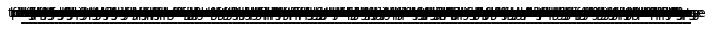

time: 13.1 s


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

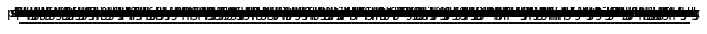

time: 13.3 s


In [15]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [16]:
images = images.to(device)
labels = labels.to(device)
outputs = model(images)

time: 14 ms


In [17]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

time: 5.79 ms


In [18]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.9999
ship - 1.0000
ship - 0.8463
ship - 0.5472
frog - 1.0000
frog - 1.0000
car - 0.9880
frog - 0.8181
cat - 0.9999
car - 1.0000
plane - 1.0000
truck - 1.0000
dog - 0.9699
horse - 1.0000
truck - 1.0000
frog - 0.9154
dog - 1.0000
horse - 1.0000
ship - 1.0000
frog - 1.0000
horse - 0.9923
plane - 1.0000
deer - 0.9132
truck - 1.0000
dog - 0.9957
bird - 0.9764
deer - 0.9977
plane - 1.0000
truck - 1.0000
frog - 1.0000
frog - 1.0000
dog - 1.0000
deer - 0.4466
dog - 0.8083
truck - 1.0000
cat - 0.9819
deer - 0.9997
car - 0.9988
truck - 1.0000
dog - 1.0000
deer - 1.0000
frog - 1.0000
cat - 0.6382
frog - 1.0000
plane - 1.0000
truck - 1.0000
cat - 0.9999
truck - 0.9919
horse - 1.0000
frog - 0.9998
truck - 0.9998
ship - 1.0000
cat - 0.7089
cat - 0.9946
ship - 1.0000
ship - 1.0000
horse - 1.0000
cat - 0.9998
dog - 0.9997
cat - 0.5916
horse - 1.0000
cat - 0.8977
frog - 0.9987
cat - 1.0000
frog - 1.0000
bird - 1.0000
car - 0.9997
bird - 1.0000
cat - 0.8749
horse - 0.9809
bird - 0.9297
frog - 1.

In [19]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 88.18%
time: 1.52 s


In [20]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 87.5
car        - 96.1
bird       - 85.2
cat        - 76.1
deer       - 87.0
dog        - 80.8
frog       - 91.0
horse      - 92.6
ship       - 93.6
truck      - 91.9
time: 3.14 ms


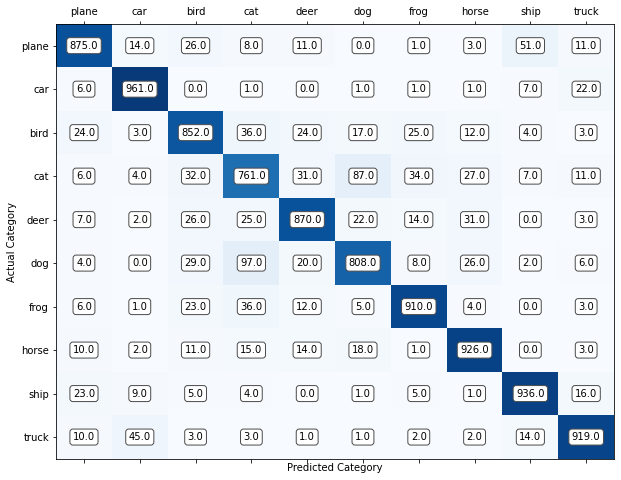

time: 435 ms


In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'),)
for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()


In [22]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           875       14        26        8         11        0         1         3         51        11        
                0.875     0.014     0.026     0.008     0.011     0.0       0.001     0.003     0.051     0.011     
car             6         961       0         1         0         1         1         1         7         22        
                0.006     0.961     0.0       0.001     0.0       0.001     0.001     0.001     0.007     0.022     
bird            24        3         852       36        24        17        25        12        4         3         
                0.024     0.003     0.852     0.036     0.024     0.017     0.025     0.012     0.004     0.003     
cat             6         4         32        761       31        87        34        27        7         11        
                0.006     0.004     0.032     0.761     0.031   

In [23]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

time: 28.7 ms


In [24]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

701466

time: 3.14 ms
